* Reference: __Algorithmic Trading: Winning Strategies and Their Rationale__ _by_ Ernest P. Chan

# Kalman Filter

This description of the Kalman filter closely follows the work of _Ernest P. Chan_ __Algorithmic Trading: Winning Strategies and Their Rationale__  [available here](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146). 

## Introduction

While for truly cointegrating price series we can use the tools described in the Cointegration module
(Johansen test, etc.), for other price series we should use other tools to estimate the
hedge ratio. For real price series, the hedge ratio can be changing in time. Using a look-back period
to estimate the parameters of a model has its disadvantages, as a short period can cut a part of the information.

This module describes a scheme that allows using the Kalman filter for hedge ratio updating, as presented in the
book by Ernest P. Chan **"Algorithmic Trading: Winning Strategies and Their Rationale"**. One of the advantages
of this approach is that we don't have to pick a weighting scheme for observations in the look-back period.

## Kalman Filter

Following the descriptions by Ernest P. Chan:

"Kalman filter is an optimal linear algorithm that updates the expected value of a hidden
variable based on the latest value of an observable variable.

It is linear because it assumes that the observable variable is a linear function of the hidden
variable with noise. It also assumes the hidden variable at time $t$ is a linear function
of itself at time $t - 1$ with noise, and that the noises present in these functions
have Gaussian distributions (and hence can be specified with an evolving covariance
matrix, assuming their means to be zero.) Because of all these linear relations, the expected
value of the hidden variable at time $t$ is also a linear function of its expected value
prior to the observation at $t$, as well as a linear function of the value of the observed
variable at $t$.

The Kalman filter is optimal in the sense that it is the best estimator
available if we assume that the noises are Gaussian, and it minimizes the mean square error of
the estimated variables."

As we're searching for the hedge ratio, we're using the following linear function:

$$y(t) = x(t) \beta(t) + \epsilon(t)$$

where $y$ and $x$ are price series of the first and the second asset, $\beta$ is the
hedge ratio that we are searching and $\epsilon$ is the Gaussian noise with variance $V_{\epsilon}$.

Allowing the spread between the $x$ and $y$ to have a nonzero mean, $\beta$
will be a vector of size $(2, 1)$ denoting both the intercept and the slope of
the linear relation between $x$ and $y$. For this needs, the $x(t)$
is augmented with a vector of ones to create an array of size $(N, 2)$.

Next, an assumption is made that the regression coefficient changes in the following way:

$$\beta(t) = \beta(t-1) + \omega(t-1)$$

where $\omega$ is a Gaussian noise with covariance $V_{\omega}$. So the regression
coefficient at time $t$ is equal to the regression coefficient at time $t-1$ plus
noise.

With this specification, the Kalman filter can generate the expected value of the hedge ratio
$\beta$ at each observation $t$.

Kalman filter also generates an estimate of the standard deviation of the forecast error
of the observable variable. It can be used as the moving standard deviation of a Bollinger band.

## Kalman Filter Strategy

Quantities that were computed using the Kalman filter can be utilized to generate trading
signals.

The forecast error $e(t)$ can be interpreted as the deviation of a pair spread from
the predicted value. This spread can be bought when it has high negative values and sold
when it has high positive values.

As a threshold for the $e(t)$, its standard deviation $\sqrt{Q(t)}$ is used:

- If $e(t) < - entry\_std\_score * \sqrt{Q(t)}$, a long position on the spread should be taken: Long $N$
  units of the $y$ asset and short $N*\beta$ units of the $x$ asset.

- If $e(t) \ge - exit\_std\_score * \sqrt{Q(t)}$, a long position on the spread should be closed.

- If $e(t) > entry\_std\_score * \sqrt{Q(t)}$, a short position on the spread should be taken: Short $N$
  units of the $y$ asset and long $N*\beta$ units of the $x$ asset.

- If $e(t) \le exit\_std\_score * \sqrt{Q(t)}$, a short position on the spread should be closed.

So it's the same logic as in the Bollinger Band Strategy from the Mean Reversion section of the Cointegration Approach module.

## Usage of the Algorithms

Let's use the above tools on real data. 

First, we will choose a pair of assets to apply the Kalman filter to. Then, from the filter output, we will generate trading signals based on the rules presented in the Kalman Filter Strategy section. Finally, we will analyze the obtained results. 

In [1]:
from IPython.display import Image

import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Loading data

As a pair to test the Kalman Filter approach we will use **EWC**(iShares MSCI Canada ETF) - **EWA**(iShares MSCI Australia ETF). This exact pair was used as an example in the book by Ernest P. Chan. We can also check if our results match the original ones for the same dataset.

In [2]:
# List of tickers to use in the analysis
tickers = ['EWC', 'EWA']

# Loading data
data =  yf.download(tickers, start="2006-04-26", end="2012-04-09")

# Taking close prices for chosen instruments
data = data["Adj Close"]

# Looking at the downloaded data
data.head()

[*********************100%***********************]  2 of 2 completed


,EWA,EWC
Date,,
2006-04-25,10.951188,18.670918
2006-04-26,11.170115,18.723619
2006-04-27,11.109015,18.595634
2006-04-28,11.170115,18.716093
2006-05-01,11.277026,18.798903


### Applying Kalman Filter

Now we'll apply the Kalman filter to our pair. As an output, we'll get the hedge ratios, intercepts, forecast errors, and standard deviations of forecast errors.

Note that when feeding observations to the Kalman Filter _update()_ function, the first parameter is the x (in our case EWA), and y is the second parameter (in our case EWC).

In [3]:
# Covariance parameters used in the example
observation_covariance = 0.001
delta = 0.0001
transition_covariance = delta / (1 - delta)

# Initialising an object containing needed methods
strategy = al.other_approaches.KalmanFilterStrategy(observation_covariance=observation_covariance,
                                                    transition_covariance=transition_covariance)

# Feeding our price series element by element to the strategy
for observations in data.values:
      strategy.update(observations[0], observations[1])

# Getting lists of hedge ratios, intercepts, forecast errors, and their standard deviations
hedge_ratios = strategy.hedge_ratios
intercepts = strategy.intercepts
forecast_errors = strategy.spread_series
error_st_dev = strategy.spread_std_series

**Note:** We're feeding price observations to the strategy one by one, so when generating internal parameters it has no access to future data.

In [4]:
# Transforming our variables into pandas formats for plotting
hedge_ratios = pd.DataFrame(hedge_ratios[10:],
                            index = data[10:].index,
                            columns =['Hedge Ratios'])

intercepts = pd.DataFrame(intercepts[10:],
                          index = data[10:].index,
                          columns =['Intercepts'])

forecast_errors = pd.DataFrame(forecast_errors[10:],
                               index = data[10:].index,
                               columns =['Forecast Errors'])

error_st_dev = pd.DataFrame(error_st_dev[10:],
                            index = data[10:].index,
                            columns =['St.D. of Forecast Errors'])

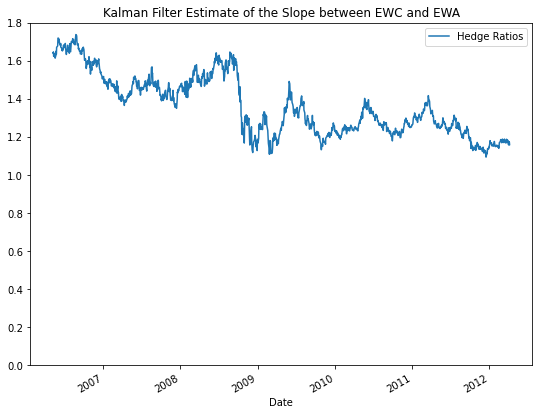

In [5]:
# Comparing generated hedge ratios with the ones from the book
hedge_ratios.plot(ylim=(0,1.8),
                  figsize = (9,7),
                  title='Kalman Filter Estimate of the Slope between EWC and EWA');

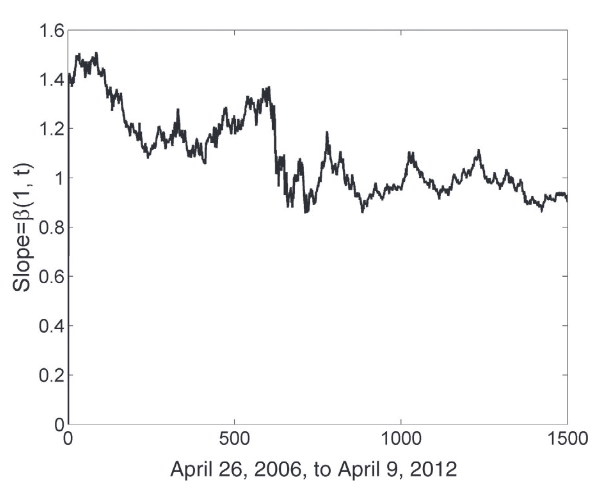

In [6]:
Image(filename='Kalman/kalman_slope.png')

_Slope estimated between EWC(y) and EWA(x) using the Kalman Filter. An example from ["Algorithmic Trading: Winning Strategies and Their Rationale"](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146) by Ernest P. Chan._

Our calculated hedge ratios are pretty similar to the ones shown in the book, however all slightly higher. This can be explained with small differences in datasets that were used.

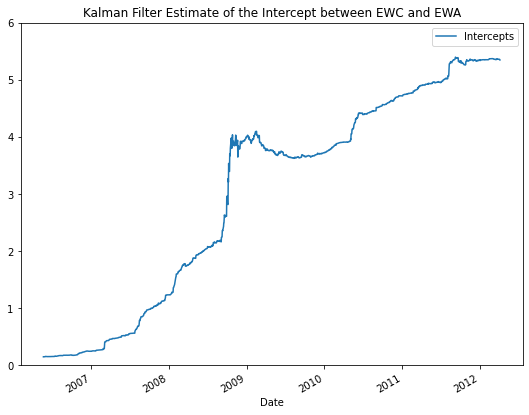

In [7]:
# Comparing generated hedge ratios with the ones from the book
intercepts[10:].plot(ylim=(0,6), 
                     figsize = (9,7),
                     title='Kalman Filter Estimate of the Intercept between EWC and EWA');

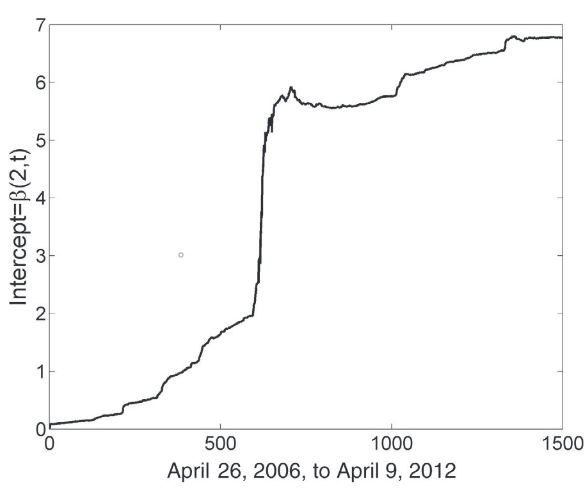

In [8]:
Image(filename='Kalman/kalman_intercept.png')

_Intercept estimated between EWC(y) and EWA(x) using the Kalman Filter. An example from ["Algorithmic Trading: Winning Strategies and Their Rationale"](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146) by Ernest P. Chan._

Our calculated intercept values are also very similar to those shown in the book, but are slightly lower. Again, we can assume it's due to differences in datasets.

### Kalman Filter Strategy

First, let's compare the values of forecast errors and their standard deviations that we got using the functions from the ArbitrageLab package with the values from the book.

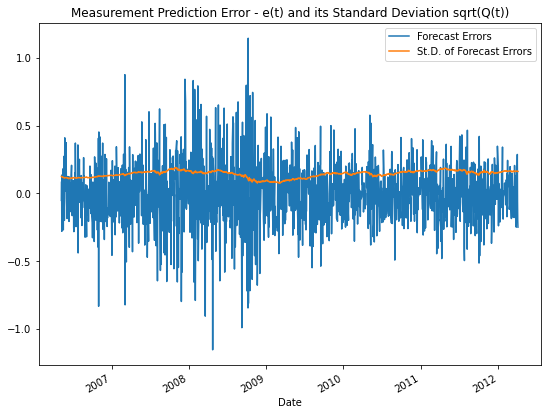

In [9]:
ax = forecast_errors.plot(figsize = (9,7))

error_st_dev.plot(ax = ax,
                  figsize = (9,7),
                  title='Measurement Prediction Error - e(t) and its Standard Deviation sqrt(Q(t))');

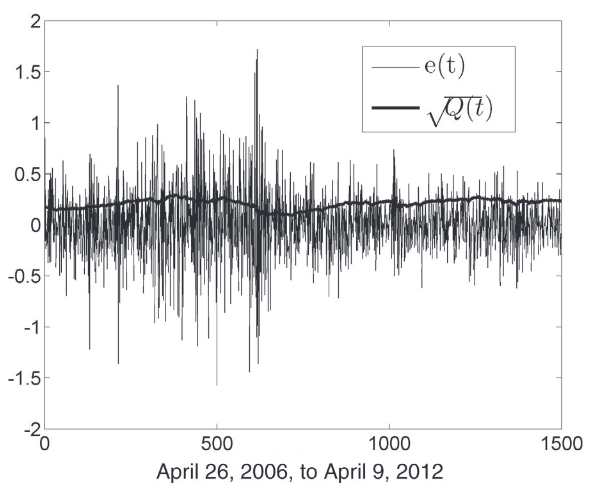

In [10]:
Image(filename='Kalman/kalman_forecast_errors.png')

_Measurement Prediction Error $e(t)$ and Standard Deviation of $e(t)$. An example from ["Algorithmic Trading: Winning Strategies and Their Rationale"](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146) by Ernest P. Chan._

Both values of forecast errors and the standard deviation are similar to the values from the book.

We can say that our implementation works on test data as expected.

Now let's run a function to generate trading signals for our dataset. As for the parameters of the Kalman Filter Strategy ($entry\_std\_score$ and $exit\_std\_score$) we can use the same values as in the book, so $entry\_std\_score = 1$ and $entry\_std\_score = 1$.

In [11]:
# Generating trading signals
trading_signals = strategy.trading_signals(entry_std_score=1, exit_std_score=1)[10:]

# Setting index for the Dataframe with trading signals
trading_signals = trading_signals.set_index(data[10:].index)

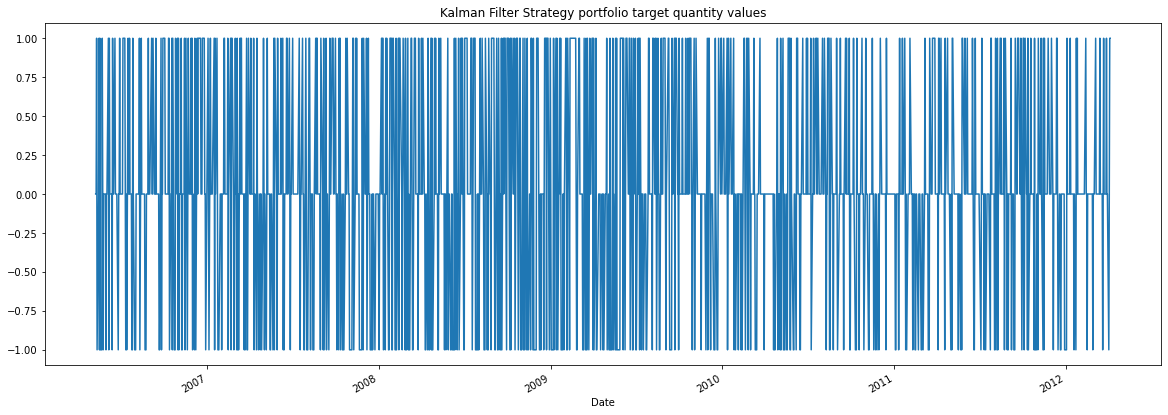

In [12]:
# Plotting obtained target quantities of portfolio to hold
trading_signals['target_quantity'].plot(figsize = (20,7),
                                        title='Kalman Filter Strategy portfolio target quantity values');

As seen, trading signals change frequently as values of errors often surpass the 3 standard deviation mark, especially during the 2008-2009 period. This should be taken into account as we are able to obtain trading signals (target quantities) only after the observations for that period is known. So using them to trade the same day results in a lookahead bias.

We can build an equity curve for this strategy on this dataset to see if it's profitable.

In [13]:
# Returns of elemrnts in our dataset
data_returns = (data / data.shift(1) - 1)[10:]

data_returns.head()

,EWA,EWC
Date,,
2006-05-09,0.014686,0.012326
2006-05-10,-0.003947,0.000786
2006-05-11,-0.000440,-0.015306
2006-05-12,-0.024670,-0.016341
2006-05-15,-0.023035,-0.022690


Now calculating weights for X and Y in a portfolio.

In a long position on spread we long $N$ units of the $y$ asset and short $N*\beta$ units of the $x$ asset.
As we want our weights to sum up to 1, we long $\frac{N}{N+N*\beta}$ of the $y$ asset and short $\frac{N*\beta}{N+N*\beta}$ of the $x$ asset.

When we short the spread, we short $N$ units of the $y$ asset and long $N*\beta$ units of the $x$ asset.
So we short $\frac{N}{N+N*\beta}$ of the $y$ asset and long $\frac{N*\beta}{N+N*\beta}$ of the $x$ asset.

In [14]:
# Weights to use when opening trades
weights_x = pd.Series(strategy.hedge_ratios[10:],
                      index = data[10:].index,
                      name = 'weight_x')

weights_x = weights_x / (weights_x + 1)
weights_y = 1 - weights_x

In [15]:
# Looking at weights series - in the case of a Kalman Filter, they are dynamic
weights_x.head()

Date
2006-05-09    0.621645
2006-05-10    0.621053
2006-05-11    0.622051
2006-05-12    0.618816
2006-05-15    0.620427
Name: weight_x, dtype: float64

Now constructing the equity curve of a portfolio.

Our asset $x$ is **EWA** and asset $y$ is **EWC**.

In [16]:
# Portfolio returns - in our case it's spread returns
portfolio_returns = data_returns['EWC'] * weights_x - data_returns['EWA'] * weights_y

# Returns of our investment portfolio - using the generated signals on portfolio returns
# Shifting our trading signals one observation ahead to avoid the lookahead bias
investment_portfolio_returns = portfolio_returns * trading_signals['target_quantity'].shift(1)

# Price of our investment portfolio
portfolio_price = (investment_portfolio_returns + 1).cumprod()

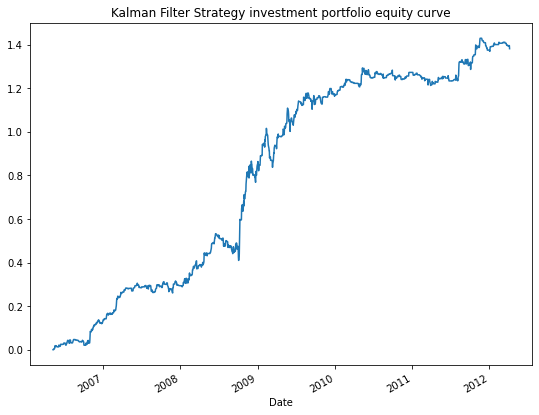

In [17]:
# Calculating the equity curve of our investemnt portfolio
equity_curve = portfolio_price - 1


# And plotting it
equity_curve.plot(figsize = (9,7),
                  title='Kalman Filter Strategy investment portfolio equity curve');

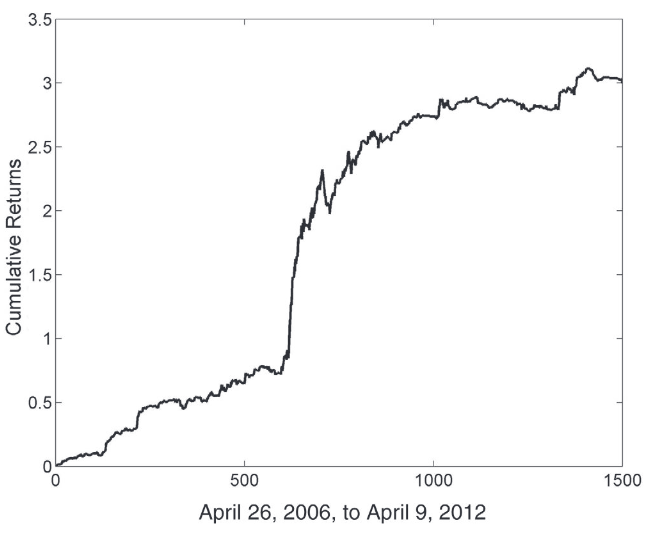

In [18]:
Image(filename='Kalman/kalman_cumulative_returns.png')

_Cumulative Returns of Kalman Filter Strategy on EWA-EWC. An example from ["Algorithmic Trading: Winning Strategies and Their Rationale"](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146) by Ernest P. Chan._

We are getting results very close to those shows in the book. The equity curve being flattened along the Y axis can be explained with
that we are normalizing our weights for them to be summed up to one.

These results look good, over the 6 year period equity curve shows an increase in the investment portfolio value from 1 to around 2,38. 

We can further test this strategy by choosing different $entry\_std\_score$ and $exit\_std\_score$ values, or adding transaction costs to see if the strategy is robust.

## Conclusion

This notebook describes the Kalman Filter Strategy class and its functionality. Also, it shows how the tools can be used on real data.

The algorithms and the descriptions used in this notebook were described by _Ernest P. Chan_ in the book __Algorithmic Trading: Winning Strategies and Their Rationale__  [available here](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146).

Key takeaways from the notebook:
- Kalman Filter Strategy is applicable when we don't have a truly cointegrating pair of price series.
- No need to pick the look-backward window for the means and the standard deviation estimation, as in strategies from the Mean Reversion approach.
- Kalman Filter approach allows estimation of changing hedge ratio between elements, whereas tools from the Cointegration Approach module offered a fixed hedge ratio.
- Kalman Filter Strategy generates trading signals based on forecast errors and their standard deviations. The logic is similar to the one from the Bollinger Bands Strategy from the Mean Reversion section of the Cointegration Approach module.
- Parameters available for optimization in the Kalman Filter Strategy are the ender and exit standard deviation scores.